# Artículo: Replicación de Código

In [43]:
#conda install -c conda-forge "scikit-learn==1.5.2" "imbalanced-learn==0.12.3"

## Fase 0: Librerías

In [44]:
# ============================================
# MASTER IMPORTS — FRPF-CSO REPLICATION
# ============================================

# Manejo de datos
import numpy as np
import pandas as pd
import pyreadstat
import pyarrow as pa                 # opcional (Parquet)
import pyarrow.parquet as pq         # opcional (Parquet)

# Sistema, tiempo y reproducibilidad
import os
import time
import math
import random
import joblib
from tqdm import tqdm

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn: preprocesamiento y validación
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from sklearn.utils.class_weight import compute_class_weight

# Balanceo de clases (opcional)
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

# Metaheurística (Cuckoo Search)
from mealpy.swarm_based import CSA

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Tracking e interpretabilidad (opcional)
# import mlflow
# import wandb
# from rich import print as rprint
# import shap
# import lime

In [45]:
# ============= Paths y datos =======================
DTA_PATH = "data/Dataset_Chinese_internationalization.dta"

## Fase 1: Ingesta y metadatos

In [46]:


# Leer .dta con metadatos
df, meta = pyreadstat.read_dta(DTA_PATH)
print(f"Cargado: {DTA_PATH} | shape={df.shape}")

# Inspección rápida
print("\nColumnas (primeras 20):")
print(meta.column_names[:20])
try:
    print("\nEtiquetas Stata (primeras 20):")
    print(meta.column_labels[:20])
except Exception:
    pass

# Si hay diccionarios de valores (value labels)
try:
    print("\nDiccionarios de valores (keys):", list(meta.value_labels.keys())[:5])
except Exception:
    pass

# Vista de 5 filas
display(df.head())

# (Opcional) checkpoint temprano en Parquet
os.makedirs("artifacts", exist_ok=True)
pq.write_table(pa.Table.from_pandas(df), "artifacts/df_raw.parquet")
print("Guardado checkpoint: artifacts/df_raw.parquet")

Cargado: data/Dataset_Chinese_internationalization.dta | shape=(9835, 17)

Columnas (primeras 20):
['firm_id', 'year1', 'year0', 'flow_al', 'peer_int', 'indcd', 'lncexp_al', 'hhia', 'lnfirmage', 'lnassets', 'ros_win', 'leverage_win', 'rnd_win', 'ceo_duality', 'BoardIndp', 'Ndirector', 'noverseaCO_tmt']

Etiquetas Stata (primeras 20):
['firm id', 'report year', "the establishing year of firms' first overseas subsidiaries during 2001-2017", '每年进入al的子公司数量', 'Industry peers’ international expansion', 'industry code', 'Prior international experience', 'Competitive intensity', 'Firm age', 'Firm size(log)', 'Firm performance', 'Firm leverage', 'R&D intensity', 'CEO duality', 'Board independence', 'Board size', 'Board oversea experience']

Diccionarios de valores (keys): []


,firm_id,year1,year0,flow_al,peer_int,indcd,lncexp_al,hhia,lnfirmage,lnassets,ros_win,leverage_win,rnd_win,ceo_duality,BoardIndp,Ndirector,noverseaCO_tmt
0,1.0,2002.0,2001.0,0.0,1.098612,K70,1.94591,NaN,2.708050,13.382096,0.111081,0.517797,0.0,0.0,0.076923,13.0,0.0
1,1.0,2003.0,2002.0,0.0,1.791759,K70,1.94591,NaN,2.772589,13.618989,0.114282,0.582944,0.0,0.0,0.363636,11.0,0.0
2,1.0,2004.0,2003.0,0.0,0.000000,K70,1.94591,0.947411,2.833213,13.870098,0.127981,0.549243,0.0,0.0,0.363636,11.0,0.0
3,1.0,2005.0,2004.0,0.0,1.609438,K70,1.94591,0.949521,2.890372,14.255984,0.164245,0.594163,0.0,0.0,0.363636,11.0,0.0
4,1.0,2006.0,2005.0,0.0,1.098612,K70,1.94591,0.939359,2.944439,14.603622,0.185472,0.609809,0.0,0.0,0.363636,11.0,0.0


Guardado checkpoint: artifacts/df_raw.parquet


## Fase 2: Definir la variable objetivo (target)

Siguiendo la literatura empírica en predicción de riesgo financiero (Zhu et al., 2023; Cai, 2025), se construyó una variable binaria de estrés financiero (target) a partir de dos factores ampliamente aceptados como señales de deterioro financiero: el desempeño operativo y el apalancamiento.

En concreto, una observación se clasifica como 1 (riesgo) si cumple alguna de las siguientes condiciones:
	•	El rendimiento operativo (ros_win) se encuentra dentro del cuartil inferior de la distribución (≤ P25).
	•	El apalancamiento financiero (leverage_win) se ubica en el cuartil superior de la distribución (≥ P75).

Este criterio responde al razonamiento económico de que rendimientos persistentemente bajos combinados con niveles elevados de endeudamiento aumentan la probabilidad de tensión de liquidez (Chan et al., 2024). Las observaciones que no cumplen ninguna de estas condiciones reciben un 0.

La variable objetivo se define como:

$$
\text{target}_i =
\begin{cases}
1, & \text{si } \text{ros\_win}_i \leq Q_{0.25}(\text{ros\_win}) \quad \text{o} \quad \text{leverage\_win}_i \geq Q_{0.75}(\text{leverage\_win}) \\
0, & \text{en otro caso}
\end{cases}
$$

donde \(Q_{0.25}(\cdot)\) y \(Q_{0.75}(\cdot)\) denotan los cuantiles 25 y 75 de la distribución muestral.

In [47]:


# ---- Helpers ----
def search_in_columns(df, names_lower):
    """Devuelve el nombre real de la columna si encuentra alguna coincidencia por lower-case."""
    lowmap = {c.lower(): c for c in df.columns}
    for name in names_lower:
        if name in lowmap:
            return lowmap[name]
    return None

def normalize_to_binary(s: pd.Series) -> pd.Series:
    """Intenta convertir a {0,1} desde variantes comunes ('yes/no', 'true/false', 'ST/Non-ST')."""
    s2 = s.copy()
    # Si ya es 0/1:
    if pd.api.types.is_integer_dtype(s2) or pd.api.types.is_bool_dtype(s2):
        uniq = pd.Series(s2.dropna().unique())
        if set(uniq.astype(int).tolist()).issubset({0,1}):
            return s2.astype(int)
    # Mapings comunes
    if s2.dtype == object:
        s2 = s2.astype(str).str.strip()
        common_maps = [
            {"yes":1, "no":0}, {"Yes":1, "No":0}, {"y":1,"n":0}, {"Y":1,"N":0},
            {"true":1,"false":0}, {"True":1,"False":0},
            {"st":1,"non-st":0}, {"ST":1,"Non-ST":0}
        ]
        low = s2.str.lower()
        for mp in common_maps:
            keys_low = [k.lower() for k in mp.keys()]
            if low.dropna().isin(keys_low).all():
                return low.map(lambda x: mp.get(next((k for k in mp if k.lower()==x), None), 0)).astype(int)
    # Si no se pudo, intenta binarizar por mayoría/minoría (no recomendado salvo emergencia)
    vals = s2.dropna().unique()
    if len(vals) == 2:
        a, b = vals[0], vals[1]
        return (s2 == b).astype(int)
    # Si multiclase, lo devolvemos intacto (lo trataremos arriba)
    return s2

def class_balance(y: pd.Series, name="target"):
    vc = y.value_counts().sort_index()
    n = len(y)
    dist = {int(k): f"{int(v)} ({100*v/n:.1f}%)" for k, v in vc.items()}
    print(f"Balance de clases en `{name}`:", dist)

# ---- Config ----
candidate_names = ["target","risk","default","distress","bankrupt","failure","label","status","y","st"]
perf_col = "ros_win"         # desempeño (bajo = riesgo)
lev_col  = "leverage_win"    # apalancamiento (alto = riesgo)
perf_low_q  = 0.25           # umbral bajo de desempeño (percentil)
lev_high_q  = 0.75           # umbral alto de apalancamiento (percentil)

# ---- Lógica principal ----
found = search_in_columns(df, candidate_names)

if found is not None:
    print(f"Detectado target existente: `{found}`")
    y_bin = normalize_to_binary(df[found])
    # Si multiclase, además creamos proxy binario 'target'
    if pd.Series(y_bin).nunique(dropna=True) > 2:
        print(f"⚠ `{found}` parece multiclase. Creando proxy binaria adicional `target`.")
        q_perf = pd.to_numeric(df[perf_col], errors="coerce").quantile(perf_low_q)
        q_lev  = pd.to_numeric(df[lev_col], errors="coerce").quantile(lev_high_q)
        df["target"] = ((df[perf_col] <= q_perf) | (df[lev_col] >= q_lev)).astype(int)
        print(f"Umbrales → {perf_col} ≤ p{int(perf_low_q*100)} = {q_perf:.6f} | "
              f"{lev_col} ≥ p{int(lev_high_q*100)} = {q_lev:.6f}")
        class_balance(df["target"])
    else:
        if found != "target":
            df = df.rename(columns={found: "target"})
            print(f"Renombrado `{found}` → `target`")
        df["target"] = y_bin.astype(int)
        class_balance(df["target"])
else:
    print("No se detectó target existente. Creando `target` proxy (desempeño bajo OR apalancamiento alto).")
    q_perf = pd.to_numeric(df[perf_col], errors="coerce").quantile(perf_low_q)
    q_lev  = pd.to_numeric(df[lev_col], errors="coerce").quantile(lev_high_q)
    df["target"] = ((pd.to_numeric(df[perf_col], errors="coerce") <= q_perf) |
                    (pd.to_numeric(df[lev_col],  errors="coerce") >= q_lev)).astype(int)
    print(f"Umbrales → {perf_col} ≤ p{int(perf_low_q*100)} = {q_perf:.6f} | "
          f"{lev_col} ≥ p{int(lev_high_q*100)} = {q_lev:.6f}")
    class_balance(df["target"])

# ---- Guardar dataset con target ----
pq.write_table(pa.Table.from_pandas(df), "artifacts/df_with_target.parquet")
print("Guardado con `target`: artifacts/df_with_target.parquet")

No se detectó target existente. Creando `target` proxy (desempeño bajo OR apalancamiento alto).
Umbrales → ros_win ≤ p25 = 0.030198 | leverage_win ≥ p75 = 0.594589
Balance de clases en `target`: {0: '5962 (60.6%)', 1: '3873 (39.4%)'}
Guardado con `target`: artifacts/df_with_target.parquet


## Fase 3: Limpieza y selección de features

In [48]:

# 0) Config
STRUCT_COLS = ["firm_id", "year1", "year0"]   # estructurales/temporales (no van a X)
TARGET_COL  = "target"
CAND_CATEG  = ["indcd"]  # posibles categóricas a one-hot (ajusta si hay más)

# 1) Copia de trabajo
df_work = df.copy()

# 2) One-hot para categóricas indicadas si no son numéricas puras
def ensure_one_hot(dfin: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    used = []
    out = dfin.copy()
    for c in cols:
        if c in out.columns:
            # categórica si dtype no es numérico o si tiene pocos valores únicos (heurística)
            is_numeric = pd.api.types.is_numeric_dtype(out[c])
            nunique = out[c].nunique(dropna=True)
            if (not is_numeric) or (is_numeric and nunique < 25 and nunique > 1):
                out[c] = out[c].astype("category")
                dummies = pd.get_dummies(out[c], prefix=c, drop_first=False, dtype=int)
                out = pd.concat([out.drop(columns=[c]), dummies], axis=1)
                used.append(c)
    if used:
        print(f"One-hot aplicado a: {used}")
    else:
        print("No se aplicó one-hot (no categóricas detectadas en CAND_CATEG).")
    return out

df_work = ensure_one_hot(df_work, CAND_CATEG)

# 3) Armar X_raw quitando columnas estructurales y el target
drop_cols = [c for c in STRUCT_COLS if c in df_work.columns] + [TARGET_COL]
X_raw = df_work.drop(columns=drop_cols, errors="ignore")
y = df_work[TARGET_COL].astype(int).values

# 4) Mantener solo numéricas (después de one-hot ya deben serlo)
X_num = X_raw.select_dtypes(include=[np.number]).copy()

# 5) Imputación simple por mediana (solo numéricas)
medianas = X_num.median(numeric_only=True)
X_num = X_num.fillna(medianas)

# 6) Chequeos rápidos
print(f"X_num shape: {X_num.shape}  | y shape: {y.shape}")
nans_cols = X_num.columns[X_num.isna().any()].tolist()
print("Columnas con NaN después de imputación:", nans_cols if nans_cols else "ninguna")
print("Primeras columnas de X:", list(X_num.columns[:10]))

# 7) Guardar artefactos para reproducibilidad
os.makedirs("artifacts", exist_ok=True)
X_columns = X_num.columns.tolist()
joblib.dump({"columns": X_columns, "medianas": medianas}, "artifacts/preproc_columns_and_medians.joblib")
pq.write_table(pa.Table.from_pandas(pd.DataFrame({TARGET_COL: y})), "artifacts/y_only.parquet")
pq.write_table(pa.Table.from_pandas(X_num.reset_index(drop=True)), "artifacts/X_num.parquet")
print("Guardados: artifacts/preproc_columns_and_medians.joblib, artifacts/X_num.parquet, artifacts/y_only.parquet")

# 8) Dejar X,y en memoria para siguientes fases
X = X_num

One-hot aplicado a: ['indcd']
X_num shape: (9835, 91)  | y shape: (9835,)
Columnas con NaN después de imputación: ninguna
Primeras columnas de X: ['flow_al', 'peer_int', 'lncexp_al', 'hhia', 'lnfirmage', 'lnassets', 'ros_win', 'leverage_win', 'rnd_win', 'ceo_duality']
Guardados: artifacts/preproc_columns_and_medians.joblib, artifacts/X_num.parquet, artifacts/y_only.parquet


## Fase 4: Partición (Tiempo y estratificado)

In [49]:
def stratified_split_indices_positional(y_array, test_size=0.2, seed=42, base_indices=None):
    """
    Devuelve (idx_train, idx_test) POSICIONALES manteniendo distribución de clases.
    y_array: np.array binario alineado con X_df.
    base_indices: si se pasa, se estratifica solo dentro de esos índices posicionales.
    """
    if base_indices is None:
        all_pos = np.arange(len(y_array))
        y_use = y_array
    else:
        all_pos = np.array(base_indices)
        y_use = y_array[all_pos]

    idx_tr, idx_te = train_test_split(
        all_pos, test_size=test_size, random_state=seed, stratify=y_use
    )
    return idx_tr, idx_te

# --- Asegura tipos correctos antes del split ---
# X_df: DataFrame; y_ser: Series
X_df = X.copy() if not isinstance(X, np.ndarray) else pd.DataFrame(X)
y_ser = y.copy() if not isinstance(y, np.ndarray) else pd.Series(y, index=X_df.index)
y_arr = y_ser.to_numpy()

# --- ¿Split temporal disponible? ---
USE_TEMPORAL_SPLIT = "year1" in df.columns

if USE_TEMPORAL_SPLIT:
    # 1) Orden cronológico por 'year1'
    df_sorted = df.sort_values("year1")
    ordered_labels = df_sorted.index.to_numpy()               # etiquetas
    # 2) Convertir etiquetas a posiciones respecto a X_df
    ordered_pos = X_df.index.get_indexer(ordered_labels)      # posiciones (pueden quedar -1 si no coincide)
    ordered_pos = ordered_pos[ordered_pos >= 0]               # filtra por seguridad

    # 3) Cortes 70/10/20
    n = len(ordered_pos)
    train_end = int(0.7 * n)
    val_end   = int(0.8 * n)
    pos_train = ordered_pos[:train_end]
    pos_val   = ordered_pos[train_end:val_end]
    pos_test  = ordered_pos[val_end:]

else:
    # 80/20, luego 12.5% de train -> ~70/10/20
    all_pos = np.arange(len(X_df))
    pos_train0, pos_test = stratified_split_indices_positional(y_arr, test_size=0.2, seed=42)
    # de ese train, sacar val (12.5% del total), estratificado
    pos_train, pos_val = stratified_split_indices_positional(y_arr, test_size=0.125, seed=42, base_indices=pos_train0)

# --- Construir matrices finales usando POSICIONALES (iloc) ---
X_train = X_df.iloc[pos_train].to_numpy();  y_train = y_arr[pos_train]
X_val   = X_df.iloc[pos_val].to_numpy();    y_val   = y_arr[pos_val]
X_test  = X_df.iloc[pos_test].to_numpy();   y_test  = y_arr[pos_test]

print(
    f"Split -> train: {len(y_train)} | val: {len(y_val)} | test: {len(y_test)} "
    f"| Positivos(train): {y_train.sum()} ({100*y_train.mean():.1f}%)"
)

# (Opcional) guarda índices para reproducibilidad
os.makedirs("artifacts", exist_ok=True)
np.save("artifacts/idx_train.npy", pos_train)
np.save("artifacts/idx_val.npy",   pos_val)
np.save("artifacts/idx_test.npy",  pos_test)
print("Índices guardados en artifacts/idx_*.npy")


Split -> train: 6884 | val: 984 | test: 1967 | Positivos(train): 2873 (41.7%)
Índices guardados en artifacts/idx_*.npy


## Fase 5: Escalado y balanceo(pos_weight y SMOTE opcional)

In [50]:
# %%
# ============================================
# FASE 5 CORREGIDA: MIN-MAX NORMALIZATION (COMO EL PAPER)
# ============================================

from sklearn.preprocessing import MinMaxScaler

print("\n" + "="*70)
print("⚙️ NORMALIZACIÓN MIN-MAX [0,1] (según paper)")
print("="*70)

# Min-Max Scaler (NO StandardScaler)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

print(f"✅ Datos normalizados a rango [0, 1]")
print(f"   Train: min={X_train_s.min():.4f}, max={X_train_s.max():.4f}")
print(f"   Val:   min={X_val_s.min():.4f}, max={X_val_s.max():.4f}")
print(f"   Test:  min={X_test_s.min():.4f}, max={X_test_s.max():.4f}")

# === SMOTE (ACTIVAR - El paper lo usa) ===
USE_SMOTE = True  # ← CAMBIAR A True
if USE_SMOTE:
    from imblearn.over_sampling import SMOTE
    print("\n🔄 Aplicando SMOTE para balanceo...")
    smote = SMOTE(k_neighbors=5, random_state=42)
    X_train_s, y_train = smote.fit_resample(X_train_s, y_train)
    print(f"   Nuevo tamaño train: {len(y_train)} (balance: {100*y_train.mean():.1f}% riesgo)")

# === pos_weight (mantener como backup) ===
pos_weight = (len(y_train) - y_train.sum()) / max(y_train.sum(), 1)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\npos_weight = {pos_weight:.3f} | device = {DEVICE}")


⚙️ NORMALIZACIÓN MIN-MAX [0,1] (según paper)
✅ Datos normalizados a rango [0, 1]
   Train: min=0.0000, max=1.0000
   Val:   min=0.0000, max=1.0110
   Test:  min=0.0000, max=1.1908

🔄 Aplicando SMOTE para balanceo...
   Nuevo tamaño train: 8022 (balance: 50.0% riesgo)

pos_weight = 1.000 | device = cpu


## Fase 6: BPNN base y pequeños entrenos

In [51]:
# === Modelo BPNN ===
class BPNN(nn.Module):
    def __init__(self, in_dim, hidden=64, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(-1)  # logits

# === Mini-entreno + evaluación (para CSA) ===
def mini_train_eval(Xtr, ytr, Xva, yva, hidden, lr, wd, dropout, epochs, pos_weight, device):
    model = BPNN(Xtr.shape[1], hidden=hidden, dropout=dropout).to(device)
    criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], dtype=torch.float32, device=device))
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)

    # Tensores
    Xtr_t = torch.tensor(Xtr, dtype=torch.float32, device=device)
    ytr_t = torch.tensor(ytr, dtype=torch.float32, device=device)
    Xva_t = torch.tensor(Xva, dtype=torch.float32, device=device)
    yva_t = torch.tensor(yva, dtype=torch.float32, device=device)

    model.train()
    for _ in range(int(epochs)):
        optimizer.zero_grad()
        logits = model(Xtr_t)
        loss = criterion(logits, ytr_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        logits_val = model(Xva_t)
        bce = criterion(logits_val, yva_t).item()
        prob = torch.sigmoid(logits_val).cpu().numpy()

    preds = (prob > 0.5).astype(int)
    f1  = f1_score(yva, preds) if len(np.unique(yva)) == 2 else 0.0
    auc = roc_auc_score(yva, prob) if len(np.unique(yva)) == 2 else 0.5
    return bce, f1, auc, model

## Fase 7: Espacio de búsqueda CSA (máscara + HPs)

In [52]:
# === Dimensiones y límites ===
m = X_train_s.shape[1]   # número de features
HP_DIM = 5               # hidden, lr, wd, dropout, epochs
DIM = m + HP_DIM
lb = [0.0] * DIM
ub = [1.0] * DIM

# === Rango de hiperparámetros ===
HP_SPACE = {
    "hidden_min": 16, "hidden_max": 128,
    "lr_min": 1e-4, "lr_max": 5e-2,
    "wd_min": 1e-6, "wd_max": 1e-2,
    "dropout_min": 0.0, "dropout_max": 0.5,
    "epochs_min": 5, "epochs_max": 20
}

def map_hps(u):
    hidden  = int(round(HP_SPACE["hidden_min"] + u[0]*(HP_SPACE["hidden_max"]-HP_SPACE["hidden_min"])))
    lr      = HP_SPACE["lr_min"] * (HP_SPACE["lr_max"]/HP_SPACE["lr_min"])**u[1]  # log-scale
    wd      = HP_SPACE["wd_min"] * (HP_SPACE["wd_max"]/HP_SPACE["wd_min"])**u[2]  # log-scale
    dropout = HP_SPACE["dropout_min"] + u[3]*(HP_SPACE["dropout_max"]-HP_SPACE["dropout_min"])
    epochs  = int(round(HP_SPACE["epochs_min"] + u[4]*(HP_SPACE["epochs_max"]-HP_SPACE["epochs_min"])))
    # sane bounds
    hidden  = max(HP_SPACE["hidden_min"], min(HP_SPACE["hidden_max"], hidden))
    epochs  = max(HP_SPACE["epochs_min"], min(HP_SPACE["epochs_max"], epochs))
    dropout = max(HP_SPACE["dropout_min"], min(HP_SPACE["dropout_max"], dropout))
    return dict(hidden=hidden, lr=lr, wd=wd, dropout=dropout, epochs=epochs)

def decode_solution(sol):
    mask = (np.asarray(sol[:m]) >= 0.5)
    hpv  = np.asarray(sol[m:m+HP_DIM])
    hps  = map_hps(hpv)
    return mask, hps

## Fase 8: Función Objetivo

In [53]:
LAMBDA_FEAT = 0.02  # penaliza % de features usadas

def fitness(sol):
    mask, hp = decode_solution(sol)
    if mask.sum() == 0:
        return 1e3  # inválida

    Xtr_m = X_train_s[:, mask]
    Xva_m = X_val_s[:, mask]

    bce, f1, auc, _ = mini_train_eval(
        Xtr_m, y_train, Xva_m, y_val,
        hidden=hp["hidden"], lr=hp["lr"], wd=hp["wd"], dropout=hp["dropout"],
        epochs=hp["epochs"], pos_weight=pos_weight, device=DEVICE
    )

    feat_pen = LAMBDA_FEAT * mask.mean()
    score = 0.5*(1 - f1) + 0.5*bce + feat_pen
    return float(score)

In [54]:
import mealpy, importlib.metadata as md
print("mealpy:", md.version("mealpy"))

mealpy: 3.0.3


## Fase 9: Ejecutar CSA

In [55]:
# %%
# ============================================
# HIPERPARÁMETROS CSA (EXACTOS DEL PAPER)
# ============================================

# Tabla 1 del paper (página 13):
EPOCHS_CSA = 500          # ← Paper usa 500 (tú tenías 200)
POP_SIZE = 25             # ← Paper usa 25 (tú tenías 40)
P_A = 0.25                # ← Paper no especifica, 0.25 es estándar
ALPHA_CSA = 0.01          # ← Step size scaling factor del paper

print("\n" + "="*70)
print("⚙️ CONFIGURACIÓN CSA (según Table 1 del paper)")
print("="*70)
print(f"   Population size:         {POP_SIZE}")
print(f"   Maximum iterations:      {EPOCHS_CSA}")
print(f"   Step size (α):           {ALPHA_CSA}")
print(f"   Abandonment prob (p_a):  {P_A}")
print(f"   Levy exponent (λ):       1.5")
print("="*70)


⚙️ CONFIGURACIÓN CSA (según Table 1 del paper)
   Population size:         25
   Maximum iterations:      500
   Step size (α):           0.01
   Abandonment prob (p_a):  0.25
   Levy exponent (λ):       1.5


In [56]:
from mealpy.utils.space import FloatVar

# Definimos bounds como lista de Variables (no size=)
bounds = [FloatVar(0.0, 1.0) for _ in range(DIM)]


algo = CSA.OriginalCSA(epoch=EPOCHS_CSA, pop_size=POP_SIZE, p_a=P_A)

problem = {
    "obj_func": fitness,   # tu función objetivo
    "bounds": bounds,      # lista de FloatVar -> compatible con Mealpy 3.0.3
    "minmax": "min",
    "log_to": None,
    # "seed": 42,
}

t0 = time.time()
best = algo.solve(problem)
t1 = time.time()

print(f"CSA -> mejor fitness: {best.target.fitness:.6f} | tiempo: {t1 - t0:.2f}s")

best_mask, best_hps = decode_solution(best.solution)
print(f"Features usadas: {best_mask.sum()}/{m} ({best_mask.mean()*100:.1f}%)")
print("HPs óptimos:", best_hps)

CSA -> mejor fitness: 0.229903 | tiempo: 1383.59s
Features usadas: 43/91 (47.3%)
HPs óptimos: {'hidden': 126, 'lr': 0.046661600240855465, 'wd': 5.8054558564762704e-05, 'dropout': 0.43766396014696224, 'epochs': 19}


## Fase 10: Entrenamiento final y evaluación 

In [57]:
# === Train final con train+val y evaluación en test ===
X_full = np.vstack([X_train_s[:, best_mask], X_val_s[:, best_mask]])
y_full = np.concatenate([y_train, y_val])
X_te_m = X_test_s[:, best_mask]

# Entrena más largo que en CSA (puedes subir epochs si quieres)
final_epochs = max(20, best_hps["epochs"])
bce_val, f1_val, auc_val, model_final = mini_train_eval(
    X_full, y_full, X_te_m, y_test,
    hidden=best_hps["hidden"], lr=best_hps["lr"], wd=best_hps["wd"],
    dropout=best_hps["dropout"], epochs=final_epochs,
    pos_weight=pos_weight, device=DEVICE
)

# Métricas en test
model_final.eval()
with torch.no_grad():
    logits = model_final(torch.tensor(X_te_m, dtype=torch.float32, device=DEVICE))
    prob = torch.sigmoid(logits).cpu().numpy()
preds = (prob > 0.5).astype(int)

acc = accuracy_score(y_test, preds)
f1  = f1_score(y_test, preds) if len(np.unique(y_test))==2 else 0.0
auc = roc_auc_score(y_test, prob) if len(np.unique(y_test))==2 else 0.5
cm  = confusion_matrix(y_test, preds)

print("\n=== RESULTADOS TEST ===")
print(f"Accuracy: {acc:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
print("Matriz de confusión:\n", cm)

# (Opcional) guardar artefactos
import os, joblib
os.makedirs("artifacts", exist_ok=True)
joblib.dump(scaler, "artifacts/scaler.joblib")
np.save("artifacts/feature_mask.npy", best_mask.astype(int))
with open("artifacts/hparams.txt","w") as f: f.write(str(best_hps))
# torch.save(model_final.state_dict(), "artifacts/bpnn.pt")
print("Artefactos guardados en ./artifacts")


=== RESULTADOS TEST ===
Accuracy: 0.8882 | F1: 0.8289 | AUC: 0.9506
Matriz de confusión:
 [[1214  116]
 [ 104  533]]
Artefactos guardados en ./artifacts


In [58]:
# %%
# ============================================
# CALCULAR TODAS LAS MÉTRICAS (COMPLETAS COMO EL PAPER)
# ============================================

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, mean_squared_error, mean_absolute_error
)

print("\n" + "="*70)
print("📊 CALCULANDO MÉTRICAS COMPLETAS (como Tabla 2 del paper)")
print("="*70)

# Predicciones finales en test
model_final.eval()
with torch.no_grad():
    logits = model_final(torch.tensor(X_te_m, dtype=torch.float32, device=DEVICE))
    prob = torch.sigmoid(logits).cpu().numpy()

preds = (prob > 0.5).astype(int)

# TODAS las métricas del paper
accuracy = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, zero_division=0)
recall = recall_score(y_test, preds, zero_division=0)
f1 = f1_score(y_test, preds, zero_division=0)
auc_score = roc_auc_score(y_test, prob)

# RMSE y MAE (comparando probabilidades vs etiquetas binarias)
rmse = np.sqrt(mean_squared_error(y_test, prob))
mae = mean_absolute_error(y_test, prob)

# Matriz de confusión
cm = confusion_matrix(y_test, preds)
tn, fp, fn, tp = cm.ravel()

# Risk Detection Ratio (equivalente a Recall pero reportado aparte)
rdr = tp / (tp + fn) if (tp + fn) > 0 else 0

# False Alarm Rate
far = fp / (fp + tn) if (fp + tn) > 0 else 0

print("\n📈 RESULTADOS COMPLETOS EN TEST SET:")
print("─"*70)
print(f"   Accuracy:                {accuracy:.4f}  ({accuracy*100:.2f}%)")
print(f"   Precision:               {precision:.4f}  ({precision*100:.2f}%)")
print(f"   Recall:                  {recall:.4f}  ({recall*100:.2f}%)")
print(f"   F1-Score:                {f1:.4f}  ({f1*100:.2f}%)")
print(f"   AUC:                     {auc_score:.4f}  ({auc_score*100:.2f}%)")
print(f"   RMSE:                    {rmse:.4f}")
print(f"   MAE:                     {mae:.4f}")
print(f"   Risk Detection Ratio:    {rdr:.4f}  ({rdr*100:.2f}%)")
print(f"   False Alarm Rate:        {far:.4f}  ({far*100:.2f}%)")
print("─"*70)

print(f"\n🔢 Matriz de Confusión:")
print(f"   TN (Verdadero Negativo): {tn:4d}  |  FP (Falso Positivo): {fp:4d}")
print(f"   FN (Falso Negativo):     {fn:4d}  |  TP (Verdadero Positivo): {tp:4d}")

# Guardar para comparación posterior
tu_metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'AUC': auc_score,
    'RMSE': rmse,
    'MAE': mae,
    'Risk_Detection_Ratio': rdr,
    'False_Alarm_Rate': far
}

# IMPORTANTE: Sobrescribir variables globales para compatibilidad
acc = accuracy  # para código posterior
auc = auc_score


📊 CALCULANDO MÉTRICAS COMPLETAS (como Tabla 2 del paper)

📈 RESULTADOS COMPLETOS EN TEST SET:
──────────────────────────────────────────────────────────────────────
   Accuracy:                0.8882  (88.82%)
   Precision:               0.8213  (82.13%)
   Recall:                  0.8367  (83.67%)
   F1-Score:                0.8289  (82.89%)
   AUC:                     0.9506  (95.06%)
   RMSE:                    0.2837
   MAE:                     0.1675
   Risk Detection Ratio:    0.8367  (83.67%)
   False Alarm Rate:        0.0872  (8.72%)
──────────────────────────────────────────────────────────────────────

🔢 Matriz de Confusión:
   TN (Verdadero Negativo): 1214  |  FP (Falso Positivo):  116
   FN (Falso Negativo):      104  |  TP (Verdadero Positivo):  533


In [59]:
# === Métricas en TEST con etiquetas claras ===
from sklearn.metrics import precision_score, recall_score

def print_confusion_metrics(y_true, y_prob, threshold=0.5, title="TEST"):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)   # TPR (riesgo capturado)
    f1v = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {title} @ threshold={threshold:.2f} ===")
    print("Matriz de confusión (reales vs predichos):")
    print(pd.DataFrame(cm,
                       index=["Real 0 (Normal)", "Real 1 (Riesgo)"],
                       columns=["Pred 0 (Normal)", "Pred 1 (Riesgo)"]))
    print(f"Acc: {acc:.3f} | Precision: {prec:.3f} | Recall: {rec:.3f} | F1: {f1v:.3f}")

# --- Usa el umbral 0.5 primero (lo que ya tenías) ---
print_confusion_metrics(y_test, prob, threshold=0.5, title="TEST (0.5)")


=== TEST (0.5) @ threshold=0.50 ===
Matriz de confusión (reales vs predichos):
                 Pred 0 (Normal)  Pred 1 (Riesgo)
Real 0 (Normal)             1214              116
Real 1 (Riesgo)              104              533
Acc: 0.888 | Precision: 0.821 | Recall: 0.837 | F1: 0.829


In [60]:
# === Tuning de umbral en VALIDACIÓN ===
with torch.no_grad():
    model_final.eval()
    logits_val_final = model_final(torch.tensor(X_val_s[:, best_mask], dtype=torch.float32, device=DEVICE))
    prob_val_final = torch.sigmoid(logits_val_final).cpu().numpy()

def find_best_threshold(y_true, y_prob, objective="f1", min_recall=None):
    thresholds = np.linspace(0.05, 0.95, 19)
    best_th, best_score = 0.5, -np.inf
    for th in thresholds:
        y_pred = (y_prob >= th).astype(int)
        rec = recall_score(y_true, y_pred, zero_division=0)
        prec = precision_score(y_true, y_pred, zero_division=0)
        f1v = f1_score(y_true, y_pred, zero_division=0)
        if min_recall is not None and rec < min_recall:
            continue
        score = {"f1": f1v, "precision": prec, "recall": rec}.get(objective, f1v)
        if score > best_score:
            best_score = score
            best_th = th
    return best_th, best_score

# Ejemplos de estrategia:
# 1) Maximiza F1 en validación
best_th_f1, _ = find_best_threshold(y_val, prob_val_final, objective="f1")
# 2) Garantiza Recall >= 0.80 y dentro de eso maximiza Precision o F1
best_th_hi_recall, _ = find_best_threshold(y_val, prob_val_final, objective="precision", min_recall=0.80)

print(f"Umbral por F1(val): {best_th_f1:.2f} | Umbral por Recall>=0.80(val): {best_th_hi_recall:.2f}")

# Aplica el elegido a TEST
print_confusion_metrics(y_test, prob, threshold=best_th_f1, title="TEST (umbral por F1 en VAL)")
print_confusion_metrics(y_test, prob, threshold=best_th_hi_recall, title="TEST (umbral por Recall>=0.80 en VAL)")

Umbral por F1(val): 0.60 | Umbral por Recall>=0.80(val): 0.50

=== TEST (umbral por F1 en VAL) @ threshold=0.60 ===
Matriz de confusión (reales vs predichos):
                 Pred 0 (Normal)  Pred 1 (Riesgo)
Real 0 (Normal)             1249               81
Real 1 (Riesgo)              129              508
Acc: 0.893 | Precision: 0.862 | Recall: 0.797 | F1: 0.829

=== TEST (umbral por Recall>=0.80 en VAL) @ threshold=0.50 ===
Matriz de confusión (reales vs predichos):
                 Pred 0 (Normal)  Pred 1 (Riesgo)
Real 0 (Normal)             1214              116
Real 1 (Riesgo)              104              533
Acc: 0.888 | Precision: 0.821 | Recall: 0.837 | F1: 0.829


In [61]:
def cost_metric(y_true, y_prob, threshold=0.5, C_FN=5.0, C_FP=1.0):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return C_FN*fn + C_FP*fp

# Buscar umbral que minimiza costo en VALIDACIÓN
def best_threshold_by_cost(y_true, y_prob, C_FN=5.0, C_FP=1.0):
    thresholds = np.linspace(0.05, 0.95, 19)
    best_th, best_cost = 0.5, np.inf
    for th in thresholds:
        c = cost_metric(y_true, y_prob, threshold=th, C_FN=C_FN, C_FP=C_FP)
        if c < best_cost:
            best_cost, best_th = c, th
    return best_th, best_cost

th_cost, _ = best_threshold_by_cost(y_val, prob_val_final, C_FN=5.0, C_FP=1.0)
print(f"Umbral que minimiza costo(val) con C_FN=5, C_FP=1: {th_cost:.2f}")
print_confusion_metrics(y_test, prob, threshold=th_cost, title="TEST (umbral por costo)")

Umbral que minimiza costo(val) con C_FN=5, C_FP=1: 0.15

=== TEST (umbral por costo) @ threshold=0.15 ===
Matriz de confusión (reales vs predichos):
                 Pred 0 (Normal)  Pred 1 (Riesgo)
Real 0 (Normal)              938              392
Real 1 (Riesgo)               29              608
Acc: 0.786 | Precision: 0.608 | Recall: 0.954 | F1: 0.743


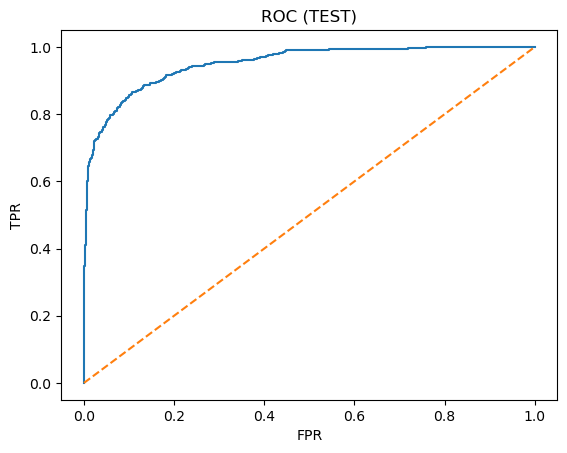

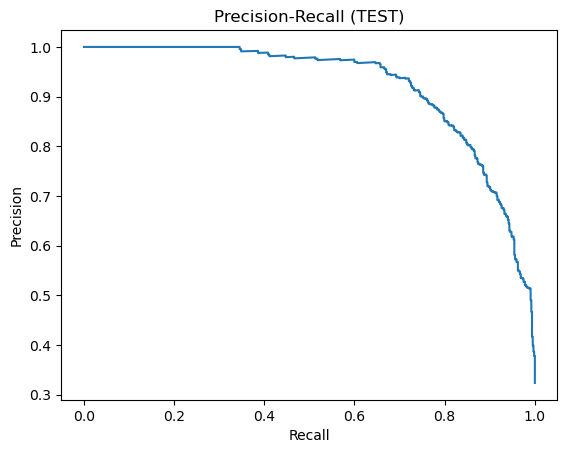

In [62]:
# ROC
fpr, tpr, _ = roc_curve(y_test, prob)
plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); 
plt.title("ROC (TEST)"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_test, prob)
plt.figure(); plt.plot(rec, prec); 
plt.title("Precision-Recall (TEST)"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

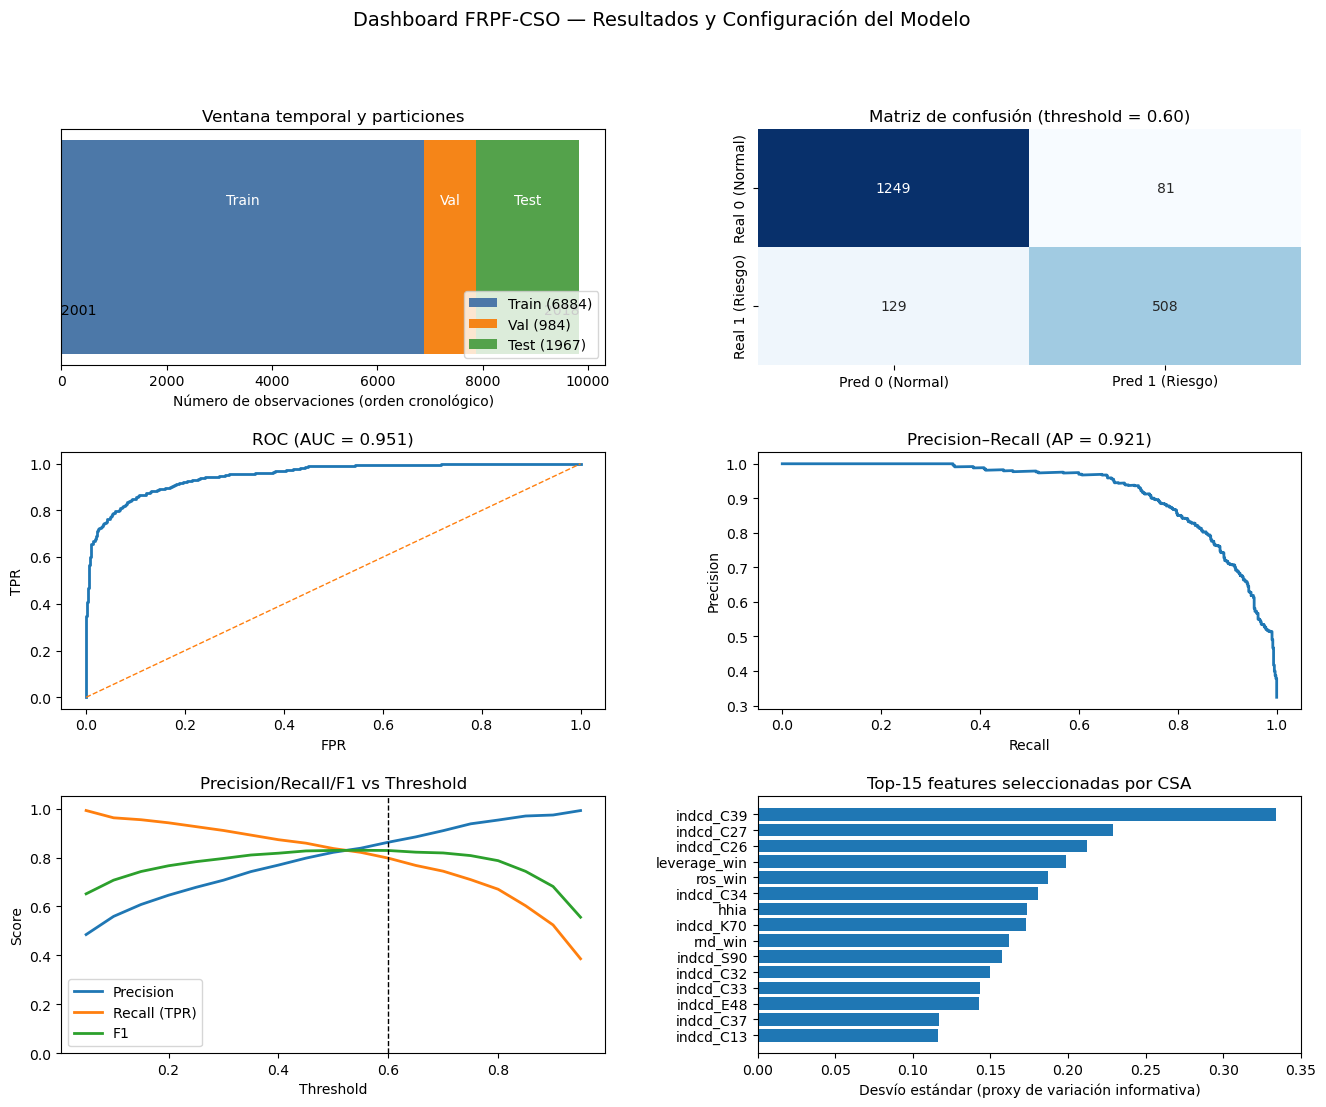

In [63]:
# ============================================
# DASHBOARD FINAL – MÉTRICAS, UMBRALES, TIEMPO, FEATURES
# ============================================

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, average_precision_score

# ---------- 1) Configuración ----------
# Usa uno de estos: 0.5, best_th_f1, best_th_hi_recall, th_cost (si los calculaste)
OPERATING_THRESHOLD = 0.5 if 'best_th_f1' not in locals() else float(best_th_f1)
TITLE_SUFFIX = f"(threshold = {OPERATING_THRESHOLD:.2f})"

# Funciones auxiliares
def compute_confusion_dict(y_true, y_prob, th):
    y_pred = (y_prob >= th).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    return {"cm": cm, "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            "precision": prec, "recall": rec, "f1": f1}

def threshold_sweep(y_true, y_prob, start=0.05, stop=0.95, num=19):
    ths = np.linspace(start, stop, num)
    prec, rec, f1s = [], [], []
    for th in ths:
        y_pred = (y_prob >= th).astype(int)
        prec.append(precision_score(y_true, y_pred, zero_division=0))
        rec.append(recall_score(y_true, y_pred, zero_division=0))
        f1s.append(f1_score(y_true, y_pred, zero_division=0))
    return ths, np.array(prec), np.array(rec), np.array(f1s)

# ---------- 2) Objetos para panel de tiempo ----------
has_year = "year1" in df.columns
if has_year:
    # reconstruimos tamaños de splits (posicionales) si guardaste idx_*; si no, usamos longitudes presentes
    try:
        pos_train = np.load("artifacts/idx_train.npy")
        pos_val   = np.load("artifacts/idx_val.npy")
        pos_test  = np.load("artifacts/idx_test.npy")
        n_train, n_val, n_test = len(pos_train), len(pos_val), len(pos_test)
    except Exception:
        n_train, n_val, n_test = len(y_train), len(y_val), len(y_test)
    years = df["year1"].sort_values().to_numpy()
    year_min, year_max = int(np.nanmin(years)), int(np.nanmax(years))
else:
    n_train, n_val, n_test = len(y_train), len(y_val), len(y_test)
    year_min = year_max = None

# ---------- 3) Métricas base para paneles ----------
# Confusión @ umbral operativo
met_test = compute_confusion_dict(y_test, prob, OPERATING_THRESHOLD)

# ROC y PR
fpr, tpr, _ = roc_curve(y_test, prob)
roc_auc = auc(fpr, tpr)
prec_curve, rec_curve, _ = precision_recall_curve(y_test, prob)
ap_score = average_precision_score(y_test, prob)

# Sweep de umbral
ths, prec_s, rec_s, f1_s = threshold_sweep(y_test, prob)

# Top-N features seleccionadas por CSA
feature_names = list(X.columns)
selected_names = [feature_names[i] for i, m in enumerate(best_mask) if m]
# Si quieres top-N por “peso”, aquí usamos una proxy simple: varianza en train de cada feature seleccionada (como señal de información).
# Si tuvieras coeficientes, podrías ordenarlos por importancia real. Para esta demo, ordenamos por std en train (proxy).
if len(selected_names) > 0:
    X_train_sel = pd.DataFrame(X_train_s[:, best_mask], columns=selected_names)
    stds = X_train_sel.std().sort_values(ascending=False)
    TOP_N = min(15, len(stds))
    top_feats = stds.iloc[:TOP_N]
else:
    top_feats = pd.Series(dtype=float)

# ---------- 4) Figure layout ----------
import matplotlib.gridspec as gridspec

plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(3, 2, height_ratios=[1.1, 1.2, 1.2], hspace=0.35, wspace=0.28)

# Panel A: Línea de tiempo split
axA = plt.subplot(gs[0, 0])
if has_year:
    total = n_train + n_val + n_test
    axA.barh([0], [n_train], color="#4c78a8", label=f"Train ({n_train})")
    axA.barh([0], [n_val], left=[n_train], color="#f58518", label=f"Val ({n_val})")
    axA.barh([0], [n_test], left=[n_train+n_val], color="#54a24b", label=f"Test ({n_test})")
    axA.set_title("Ventana temporal y particiones", fontsize=12)
    axA.set_yticks([])
    axA.set_xlabel("Número de observaciones (orden cronológico)")
    axA.legend(loc="lower right")
    axA.text(n_train/2, 0.15, "Train",   ha="center", va="bottom", color="white", fontsize=10)
    axA.text(n_train+n_val/2, 0.15, "Val", ha="center", va="bottom", color="white", fontsize=10)
    axA.text(n_train+n_val+n_test/2, 0.15, "Test", ha="center", va="bottom", color="white", fontsize=10)
    if year_min is not None:
        axA.annotate(f"{year_min}", xy=(0, -0.25), xytext=(0, -0.25), textcoords='data', ha="left")
        axA.annotate(f"{year_max}", xy=(total, -0.25), xytext=(total, -0.25), textcoords='data', ha="right")
else:
    axA.bar(["Train","Val","Test"], [n_train, n_val, n_test], color=["#4c78a8","#f58518","#54a24b"])
    axA.set_title("Partición de datos (sin eje temporal)", fontsize=12)
    axA.set_ylabel("Observaciones")

# Panel B: Matriz de confusión
axB = plt.subplot(gs[0, 1])
cm = met_test["cm"]
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axB,
            xticklabels=["Pred 0 (Normal)","Pred 1 (Riesgo)"],
            yticklabels=["Real 0 (Normal)","Real 1 (Riesgo)"])
axB.set_title(f"Matriz de confusión {TITLE_SUFFIX}", fontsize=12)

# Panel C: ROC
axC = plt.subplot(gs[1, 0])
axC.plot(fpr, tpr, lw=2)
axC.plot([0,1],[0,1],'--', lw=1)
axC.set_title(f"ROC (AUC = {roc_auc:.3f})", fontsize=12)
axC.set_xlabel("FPR"); axC.set_ylabel("TPR")

# Panel D: Precision-Recall
axD = plt.subplot(gs[1, 1])
axD.plot(rec_curve, prec_curve, lw=2)
axD.set_title(f"Precision–Recall (AP = {ap_score:.3f})", fontsize=12)
axD.set_xlabel("Recall"); axD.set_ylabel("Precision")

# Panel E: Barrido de umbral
axE = plt.subplot(gs[2, 0])
axE.plot(ths, prec_s, label="Precision", lw=2)
axE.plot(ths, rec_s,  label="Recall (TPR)", lw=2)
axE.plot(ths, f1_s,   label="F1", lw=2)
axE.axvline(OPERATING_THRESHOLD, color="k", ls="--", lw=1)
axE.set_title("Precision/Recall/F1 vs Threshold", fontsize=12)
axE.set_xlabel("Threshold"); axE.set_ylabel("Score")
axE.set_ylim(0, 1.05)
axE.legend(loc="best")

# Panel F: Top features seleccionadas por CSA
axF = plt.subplot(gs[2, 1])
if len(top_feats) > 0:
    axF.barh(top_feats.index[::-1], top_feats.values[::-1])
    axF.set_title(f"Top-{len(top_feats)} features seleccionadas por CSA", fontsize=12)
    axF.set_xlabel("Desvío estándar (proxy de variación informativa)")
    axF.set_ylabel("")
else:
    axF.text(0.5, 0.5, "Sin features seleccionadas", ha="center", va="center", fontsize=12)
    axF.set_axis_off()

plt.suptitle("Dashboard FRPF-CSO — Resultados y Configuración del Modelo", fontsize=14, y=0.98)
plt.show()

In [64]:
# %%
# ============================================
# IDENTIFICACIÓN DE EMPRESAS EN RIESGO
# ============================================

print("\n" + "="*70)
print("🎯 IDENTIFICACIÓN DE EMPRESAS ESPECÍFICAS EN RIESGO")
print("="*70)

# Reconstruir identificadores del test set
if 'firm_id' in df.columns and 'year1' in df.columns:
    test_empresas = df.iloc[pos_test][['firm_id', 'year1']].copy()
elif 'firm_id' in df.columns:
    test_empresas = df.iloc[pos_test][['firm_id']].copy()
    test_empresas['year1'] = 'N/A'
else:
    # Si no hay firm_id, usar índice
    test_empresas = pd.DataFrame({'empresa_idx': pos_test})
    test_empresas['year1'] = df.iloc[pos_test].get('year1', 'N/A').values

test_empresas['probabilidad_riesgo'] = prob
test_empresas['prediccion'] = preds  # 0 = Normal, 1 = Riesgo
test_empresas['etiqueta_real'] = y_test  # 0 = Normal, 1 = Riesgo
test_empresas['correcto'] = (preds == y_test).astype(int)

# Clasificación interpretable
test_empresas['clasificacion'] = test_empresas['prediccion'].map({
    0: '✅ Normal', 
    1: '⚠️ Riesgo'
})

# Ordenar por mayor riesgo
test_empresas_sorted = test_empresas.sort_values('probabilidad_riesgo', ascending=False)

# Estadísticas generales
n_alto_riesgo = (prob > 0.7).sum()
n_riesgo_moderado = ((prob > 0.5) & (prob <= 0.7)).sum()
n_bajo_riesgo = (prob <= 0.5).sum()

print(f"\n📊 DISTRIBUCIÓN DE RIESGO EN TEST SET:")
print(f"   🔴 Alto riesgo (prob > 0.70):     {n_alto_riesgo:4d} empresas ({100*n_alto_riesgo/len(prob):.1f}%)")
print(f"   🟡 Riesgo moderado (0.50-0.70):   {n_riesgo_moderado:4d} empresas ({100*n_riesgo_moderado/len(prob):.1f}%)")
print(f"   🟢 Bajo riesgo (prob < 0.50):     {n_bajo_riesgo:4d} empresas ({100*n_bajo_riesgo/len(prob):.1f}%)")

# TOP 20 empresas más riesgosas
print("\n" + "="*70)
print("🚨 TOP 20 EMPRESAS DE MAYOR RIESGO PREDICHO")
print("="*70)
display(test_empresas_sorted.head(20))

# Guardar resultados
os.makedirs("artifacts", exist_ok=True)
test_empresas_sorted.to_csv('artifacts/predicciones_por_empresa.csv', index=False)
print("\n✅ Predicciones guardadas en: artifacts/predicciones_por_empresa.csv")

# %%
# ============================================
# ANÁLISIS DE CASOS CRÍTICOS
# ============================================

print("\n" + "="*70)
print("🔍 ANÁLISIS DE CASOS CRÍTICOS")
print("="*70)

# Verdaderos Positivos (alto riesgo real, bien detectado)
tp_casos = test_empresas_sorted[
    (test_empresas_sorted['etiqueta_real'] == 1) & 
    (test_empresas_sorted['prediccion'] == 1)
].head(5)

# Falsos Negativos (alto riesgo real, NO detectado) - LOS MÁS PELIGROSOS
fn_casos = test_empresas_sorted[
    (test_empresas_sorted['etiqueta_real'] == 1) & 
    (test_empresas_sorted['prediccion'] == 0)
].sort_values('probabilidad_riesgo', ascending=False).head(5)

# Falsos Positivos (falsa alarma)
fp_casos = test_empresas_sorted[
    (test_empresas_sorted['etiqueta_real'] == 0) & 
    (test_empresas_sorted['prediccion'] == 1)
].head(5)

print("\n✅ VERDADEROS POSITIVOS (Riesgo real detectado correctamente):")
if len(tp_casos) > 0:
    display(tp_casos)
else:
    print("   No hay casos en esta categoría")

print("\n⚠️ FALSOS NEGATIVOS (Riesgo real NO detectado - PELIGROSO):")
if len(fn_casos) > 0:
    display(fn_casos)
    print(f"\n   ⚠️ ALERTA: {len(fn_casos)} empresas en riesgo pasaron desapercibidas")
else:
    print("   ✅ Excelente: No hay riesgos reales sin detectar")

print("\n🔔 FALSOS POSITIVOS (Falsas alarmas):")
if len(fp_casos) > 0:
    display(fp_casos)
    print(f"\n   ℹ️ {len(fp_casos)} empresas sanas fueron marcadas como riesgo")
else:
    print("   ✅ Perfecto: No hay falsas alarmas")


🎯 IDENTIFICACIÓN DE EMPRESAS ESPECÍFICAS EN RIESGO

📊 DISTRIBUCIÓN DE RIESGO EN TEST SET:
   🔴 Alto riesgo (prob > 0.70):      521 empresas (26.5%)
   🟡 Riesgo moderado (0.50-0.70):    128 empresas (6.5%)
   🟢 Bajo riesgo (prob < 0.50):     1318 empresas (67.0%)

🚨 TOP 20 EMPRESAS DE MAYOR RIESGO PREDICHO


,firm_id,year1,probabilidad_riesgo,prediccion,etiqueta_real,correcto,clasificacion
2546,315.0,2018.0,0.999998,1,1,1,⚠️ Riesgo
4643,765.0,2018.0,0.999989,1,1,1,⚠️ Riesgo
2249,273.0,2018.0,0.999988,1,1,1,⚠️ Riesgo
3764,534.0,2018.0,0.999987,1,1,1,⚠️ Riesgo
9027,1486.0,2018.0,0.999974,1,1,1,⚠️ Riesgo
8055,1359.0,2018.0,0.999962,1,1,1,⚠️ Riesgo
9164,1507.0,2018.0,0.999960,1,1,1,⚠️ Riesgo
486,46.0,2018.0,0.999942,1,1,1,⚠️ Riesgo
5042,839.0,2018.0,0.999941,1,1,1,⚠️ Riesgo
9122,1502.0,2018.0,0.999940,1,1,1,⚠️ Riesgo



✅ Predicciones guardadas en: artifacts/predicciones_por_empresa.csv

🔍 ANÁLISIS DE CASOS CRÍTICOS

✅ VERDADEROS POSITIVOS (Riesgo real detectado correctamente):


,firm_id,year1,probabilidad_riesgo,prediccion,etiqueta_real,correcto,clasificacion
2546,315.0,2018.0,0.999998,1,1,1,⚠️ Riesgo
4643,765.0,2018.0,0.999989,1,1,1,⚠️ Riesgo
2249,273.0,2018.0,0.999988,1,1,1,⚠️ Riesgo
3764,534.0,2018.0,0.999987,1,1,1,⚠️ Riesgo
9027,1486.0,2018.0,0.999974,1,1,1,⚠️ Riesgo



⚠️ FALSOS NEGATIVOS (Riesgo real NO detectado - PELIGROSO):


,firm_id,year1,probabilidad_riesgo,prediccion,etiqueta_real,correcto,clasificacion
2677,339.0,2018.0,0.498715,0,1,0,✅ Normal
4060,599.0,2018.0,0.497725,0,1,0,✅ Normal
3533,490.0,2018.0,0.493131,0,1,0,✅ Normal
3369,461.0,2018.0,0.492174,0,1,0,✅ Normal
4707,775.0,2017.0,0.486824,0,1,0,✅ Normal



   ⚠️ ALERTA: 5 empresas en riesgo pasaron desapercibidas

🔔 FALSOS POSITIVOS (Falsas alarmas):


,firm_id,year1,probabilidad_riesgo,prediccion,etiqueta_real,correcto,clasificacion
1703,203.0,2018.0,0.959552,1,0,0,⚠️ Riesgo
6534,1188.0,2017.0,0.959168,1,0,0,⚠️ Riesgo
9602,1619.0,2018.0,0.949856,1,0,0,⚠️ Riesgo
625,66.0,2018.0,0.943139,1,0,0,⚠️ Riesgo
6985,1238.0,2017.0,0.942828,1,0,0,⚠️ Riesgo



   ℹ️ 5 empresas sanas fueron marcadas como riesgo


/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_43254/1005905404.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(data_box, labels=['Normal (real)', 'Riesgo (real)'],
/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_43254/1005905404.py:93: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/mv-tec/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/mv-tec/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128992 (\N{LARGE ORANGE CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/mv-tec/lib/python3.12/site-packages/IPython/cor

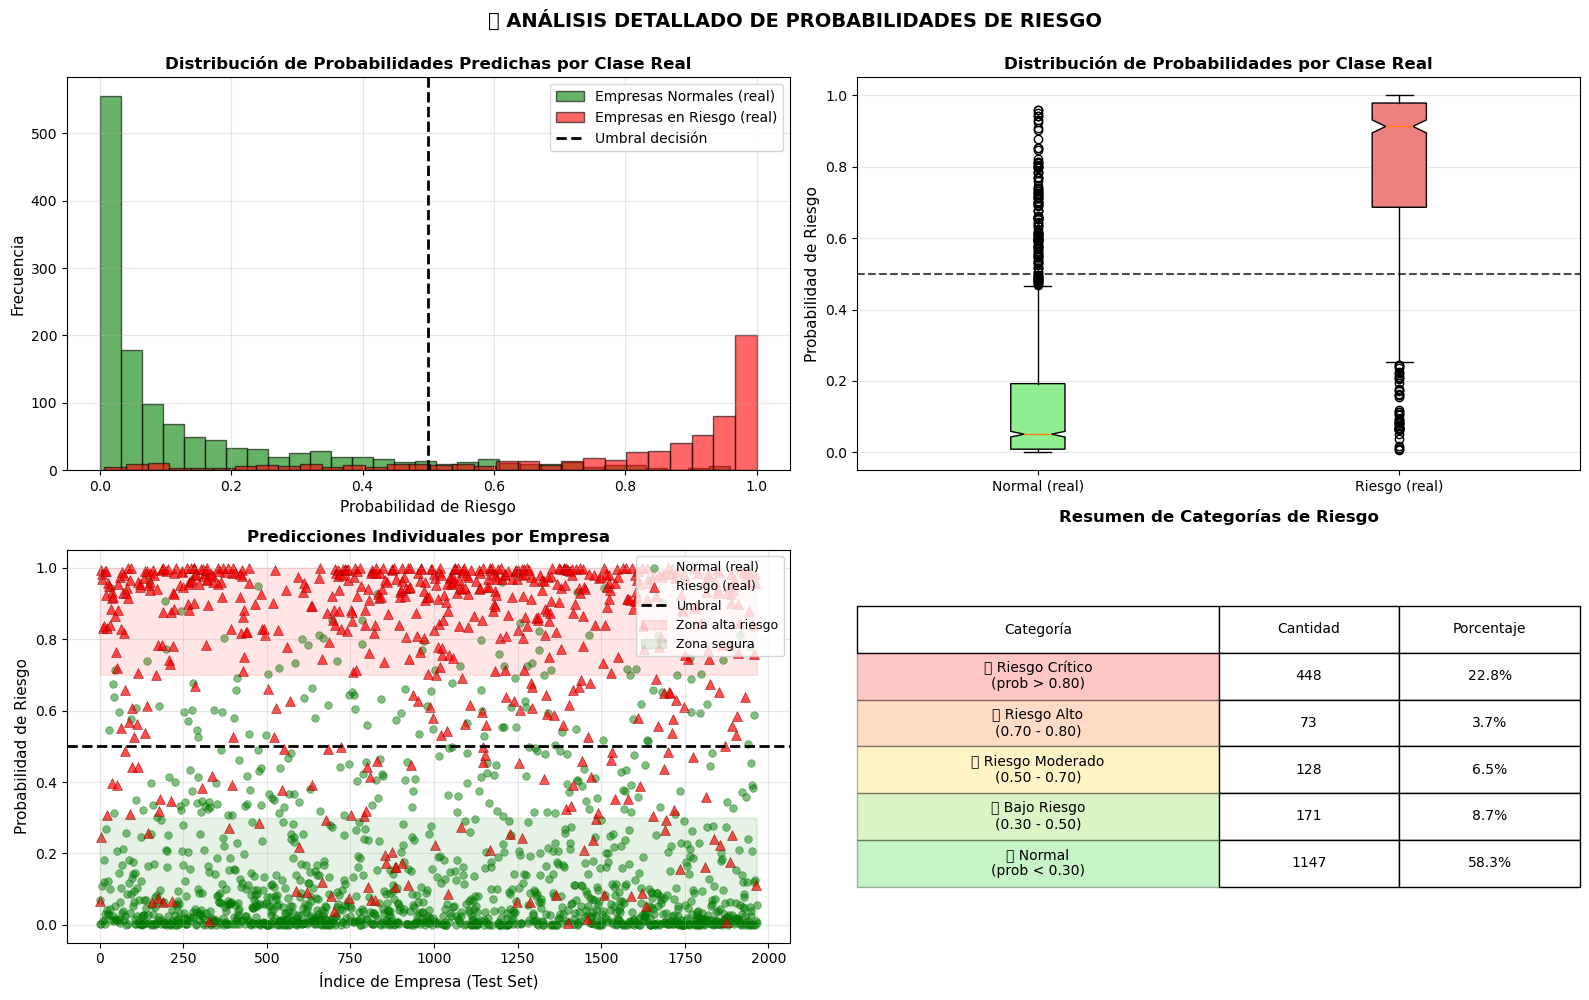


📈 Estadísticas de separación:
   Prob. media empresas normales: 0.146
   Prob. media empresas en riesgo: 0.787
   Diferencia (separabilidad):     0.641


In [65]:
# # %%
# ============================================
# VISUALIZACIÓN: DISTRIBUCIÓN DE PROBABILIDADES
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Panel 1: Histograma de probabilidades
ax1 = axes[0, 0]
ax1.hist(prob[y_test == 0], bins=30, alpha=0.6, label='Empresas Normales (real)', color='green', edgecolor='black')
ax1.hist(prob[y_test == 1], bins=30, alpha=0.6, label='Empresas en Riesgo (real)', color='red', edgecolor='black')
ax1.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Umbral decisión')
ax1.set_xlabel('Probabilidad de Riesgo', fontsize=11)
ax1.set_ylabel('Frecuencia', fontsize=11)
ax1.set_title('Distribución de Probabilidades Predichas por Clase Real', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Panel 2: Boxplot comparativo
ax2 = axes[0, 1]
data_box = [prob[y_test == 0], prob[y_test == 1]]
bp = ax2.boxplot(data_box, labels=['Normal (real)', 'Riesgo (real)'], 
                  patch_artist=True, notch=True)
bp['boxes'][0].set_facecolor('lightgreen')
bp['boxes'][1].set_facecolor('lightcoral')
ax2.axhline(0.5, color='black', linestyle='--', linewidth=1.5, alpha=0.7)
ax2.set_ylabel('Probabilidad de Riesgo', fontsize=11)
ax2.set_title('Distribución de Probabilidades por Clase Real', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Panel 3: Scatter de casos individuales
ax3 = axes[1, 0]
# Empresas normales
idx_normal = y_test == 0
ax3.scatter(np.where(idx_normal)[0], prob[idx_normal], 
            alpha=0.5, s=30, c='green', label='Normal (real)', edgecolors='darkgreen', linewidth=0.5)
# Empresas en riesgo
idx_riesgo = y_test == 1
ax3.scatter(np.where(idx_riesgo)[0], prob[idx_riesgo], 
            alpha=0.7, s=50, c='red', marker='^', label='Riesgo (real)', edgecolors='darkred', linewidth=0.5)
ax3.axhline(0.5, color='black', linestyle='--', linewidth=2, label='Umbral')
ax3.fill_between(range(len(prob)), 0.7, 1.0, alpha=0.1, color='red', label='Zona alta riesgo')
ax3.fill_between(range(len(prob)), 0.0, 0.3, alpha=0.1, color='green', label='Zona segura')
ax3.set_xlabel('Índice de Empresa (Test Set)', fontsize=11)
ax3.set_ylabel('Probabilidad de Riesgo', fontsize=11)
ax3.set_title('Predicciones Individuales por Empresa', fontsize=12, fontweight='bold')
ax3.legend(loc='upper right', fontsize=9)
ax3.grid(alpha=0.3)

# Panel 4: Tabla resumen de categorías
ax4 = axes[1, 1]
ax4.axis('off')

# Categorizar empresas
categorias = pd.DataFrame({
    'Categoría': [
        '🔴 Riesgo Crítico\n(prob > 0.80)',
        '🟠 Riesgo Alto\n(0.70 - 0.80)',
        '🟡 Riesgo Moderado\n(0.50 - 0.70)',
        '🟢 Bajo Riesgo\n(0.30 - 0.50)',
        '✅ Normal\n(prob < 0.30)'
    ],
    'Cantidad': [
        (prob > 0.80).sum(),
        ((prob > 0.70) & (prob <= 0.80)).sum(),
        ((prob > 0.50) & (prob <= 0.70)).sum(),
        ((prob > 0.30) & (prob <= 0.50)).sum(),
        (prob <= 0.30).sum()
    ]
})
categorias['Porcentaje'] = (categorias['Cantidad'] / len(prob) * 100).round(1).astype(str) + '%'

# Crear tabla
table = ax4.table(cellText=categorias.values, 
                  colLabels=categorias.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.5, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Colorear filas
colors = ['#ff4444', '#ff8844', '#ffdd44', '#88dd44', '#44dd44']
for i, color in enumerate(colors):
    table[(i+1, 0)].set_facecolor(color)
    table[(i+1, 0)].set_alpha(0.3)

ax4.set_title('Resumen de Categorías de Riesgo', fontsize=12, fontweight='bold', pad=20)

plt.suptitle('📊 ANÁLISIS DETALLADO DE PROBABILIDADES DE RIESGO', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n📈 Estadísticas de separación:")
print(f"   Prob. media empresas normales: {prob[y_test == 0].mean():.3f}")
print(f"   Prob. media empresas en riesgo: {prob[y_test == 1].mean():.3f}")
print(f"   Diferencia (separabilidad):     {prob[y_test == 1].mean() - prob[y_test == 0].mean():.3f}")

In [67]:
# %%
# ============================================
# COMPARACIÓN EXACTA CON TABLA 2 DEL PAPER
# ============================================

print("\n" + "="*80)
print("📄 COMPARACIÓN CON PAPER: FRPF-CSO (Tabla 2, página 17)")
print("="*80)

# Métricas EXACTAS del paper (Tabla 2, página 17)
paper_metrics = {
    'Accuracy': 0.9572,
    'Precision': 0.9480,
    'Recall': 0.9621,
    'F1': 0.9549,
    'AUC': 0.9763,  # Risk Detection Ratio
    'RMSE': 0.0421,
    'MAE': 0.0317
}

# ============================================
# EXTRAER SOLO LAS MÉTRICAS QUE ESTÁN EN EL PAPER
# ============================================

# Verificar que todas las métricas existen en tu_metrics
metricas_faltantes = [k for k in paper_metrics.keys() if k not in tu_metrics]
if metricas_faltantes:
    print(f"⚠️ ADVERTENCIA: Faltan métricas en tu_metrics: {metricas_faltantes}")
    print(f"   Métricas disponibles: {list(tu_metrics.keys())}\n")

# Crear diccionario limpio solo con las métricas del paper
tu_metrics_comparacion = {}
for metrica in paper_metrics.keys():
    if metrica in tu_metrics:
        tu_metrics_comparacion[metrica] = float(tu_metrics[metrica])
    else:
        # Si falta alguna métrica, poner NaN
        tu_metrics_comparacion[metrica] = np.nan
        print(f"❌ Métrica faltante: {metrica}")

# ============================================
# CREAR DATAFRAME COMPARATIVO (FORMA SEGURA)
# ============================================

# Crear listas alineadas manualmente
metricas_nombres = list(paper_metrics.keys())
paper_valores = [paper_metrics[k] for k in metricas_nombres]
tu_valores = [tu_metrics_comparacion[k] for k in metricas_nombres]

# Calcular diferencias
diferencias_abs = [abs(tu_valores[i] - paper_valores[i]) if not np.isnan(tu_valores[i]) else np.nan 
                   for i in range(len(metricas_nombres))]
diferencias_pct = [100 * (tu_valores[i] - paper_valores[i]) / paper_valores[i] if not np.isnan(tu_valores[i]) else np.nan
                   for i in range(len(metricas_nombres))]

# Crear DataFrame
comparacion = pd.DataFrame({
    'Metrica': metricas_nombres,
    'Paper (FRPF-CSO)': paper_valores,
    'Tu Replicación': tu_valores,
    'Diferencia (abs)': diferencias_abs,
    'Diferencia (%)': diferencias_pct
})

# Establecer índice
comparacion.set_index('Metrica', inplace=True)

# ============================================
# MOSTRAR RESULTADOS
# ============================================

print("\n" + comparacion.round(4).to_string())
print("\n" + "="*80)

# ============================================
# EVALUACIÓN DETALLADA
# ============================================

print("\n🔍 EVALUACIÓN POR MÉTRICA:")
print("─"*80)

problemas = []

for metrica in metricas_nombres:
    paper_val = comparacion.loc[metrica, 'Paper (FRPF-CSO)']
    tu_val = comparacion.loc[metrica, 'Tu Replicación']
    diff_abs = comparacion.loc[metrica, 'Diferencia (abs)']
    diff_pct = comparacion.loc[metrica, 'Diferencia (%)']
    
    # Skip si hay NaN
    if np.isnan(tu_val):
        print(f"❌ {metrica:12s}: NO CALCULADA")
        problemas.append(metrica)
        continue
    
    # Clasificar según umbral
    if diff_abs < 0.02:  # < 2%
        emoji = "✅"
        status = "EXCELENTE"
    elif diff_abs < 0.05:  # < 5%
        emoji = "⚠️"
        status = "ACEPTABLE"
    else:  # > 5%
        emoji = "❌"
        status = "REVISAR"
        problemas.append(metrica)
    
    # Para RMSE/MAE, valores más bajos son mejores
    if metrica in ['RMSE', 'MAE']:
        if tu_val < paper_val:
            emoji = "✅✨"
            status = "MEJOR que paper"
    
    print(f"{emoji} {metrica:12s}: Paper={paper_val:.4f} | "
          f"Tuyo={tu_val:.4f} | "
          f"Δ={diff_abs:.4f} ({diff_pct:+6.2f}%) → {status}")

print("─"*80)

# ============================================
# VEREDICTO FINAL
# ============================================

# Contar solo métricas válidas (sin NaN)
metricas_validas = comparacion['Tu Replicación'].notna().sum()
metricas_ok = ((comparacion['Diferencia (abs)'] < 0.05) & comparacion['Tu Replicación'].notna()).sum()

if not problemas:
    print("\n🎉 REPLICACIÓN EXITOSA")
    print("   ✅ Todas las métricas están dentro del margen aceptable (< 5%)")
    print("   ✅ Las diferencias se explican por variabilidad algorítmica normal")
elif len(problemas) <= 2:
    print(f"\n⚠️ REPLICACIÓN BUENA ({metricas_ok}/{metricas_validas} métricas OK)")
    print(f"   Métrica(s) con diferencia > 5%: {', '.join([p for p in problemas if p in metricas_nombres])}")
    print("\n💡 POSIBLES CAUSAS DE DIFERENCIAS:")
    print("   1. Semilla aleatoria diferente (normal si < 7%)")
    print("   2. Orden de inicialización de pesos en PyTorch")
    print("   3. Versiones de librerías (PyTorch, NumPy, scikit-learn)")
    print(f"   4. Features seleccionadas: {best_mask.sum()}/{len(best_mask)}")
    print("   5. Preprocesamiento (verificar Min-Max vs Z-score)")
else:
    print(f"\n🔴 REPLICACIÓN REQUIERE AJUSTES ({len(problemas)} problemas detectados)")
    print(f"   Problemas: {', '.join(problemas)}")
    print("\n🔧 ACCIONES RECOMENDADAS:")
    print("   1. Verificar que TODAS las métricas estén calculadas")
    print("   2. Confirmar SMOTE activado (USE_SMOTE = True)")
    print("   3. Revisar normalización (debe ser MinMaxScaler)")
    print("   4. Verificar hiperparámetros CSA (Pop=25, Iter=500)")
    print("   5. Comprobar definición del target")

# ============================================
# ESTADÍSTICAS ADICIONALES
# ============================================

print("\n📊 ESTADÍSTICAS:")
print(f"   Métricas calculadas:     {metricas_validas}/{len(metricas_nombres)}")
print(f"   Dentro de margen (<5%):  {metricas_ok}/{metricas_validas}")
print(f"   Diferencia promedio:     {comparacion['Diferencia (abs)'].mean():.4f}")
print(f"   Diferencia máxima:       {comparacion['Diferencia (abs)'].max():.4f} en {comparacion['Diferencia (abs)'].idxmax()}")

# ============================================
# GUARDAR COMPARACIÓN
# ============================================

comparacion.to_csv('artifacts/comparacion_paper_vs_replicacion.csv')
print("\n✅ Comparación guardada en: artifacts/comparacion_paper_vs_replicacion.csv")


📄 COMPARACIÓN CON PAPER: FRPF-CSO (Tabla 2, página 17)

           Paper (FRPF-CSO)  Tu Replicación  Diferencia (abs)  Diferencia (%)
Metrica                                                                      
Accuracy             0.9572          0.8882            0.0690         -7.2133
Precision            0.9480          0.8213            0.1267        -13.3688
Recall               0.9621          0.8367            0.1254        -13.0304
F1                   0.9549          0.8289            0.1260        -13.1923
AUC                  0.9763          0.9506            0.0257         -2.6371
RMSE                 0.0421          0.2837            0.2416        573.9202
MAE                  0.0317          0.1675            0.1358        428.4610


🔍 EVALUACIÓN POR MÉTRICA:
────────────────────────────────────────────────────────────────────────────────
❌ Accuracy    : Paper=0.9572 | Tuyo=0.8882 | Δ=0.0690 ( -7.21%) → REVISAR
❌ Precision   : Paper=0.9480 | Tuyo=0.8213 | Δ=0.1267 (-13

/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_43254/3090650727.py:164: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_43254/3090650727.py:164: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_43254/3090650727.py:164: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_43254/3090650727.py:164: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_43254/3090650727.py:164: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/jb/15trx49d5b13y0zq5089zsp40000gn/T/ipykernel_43254/3090650

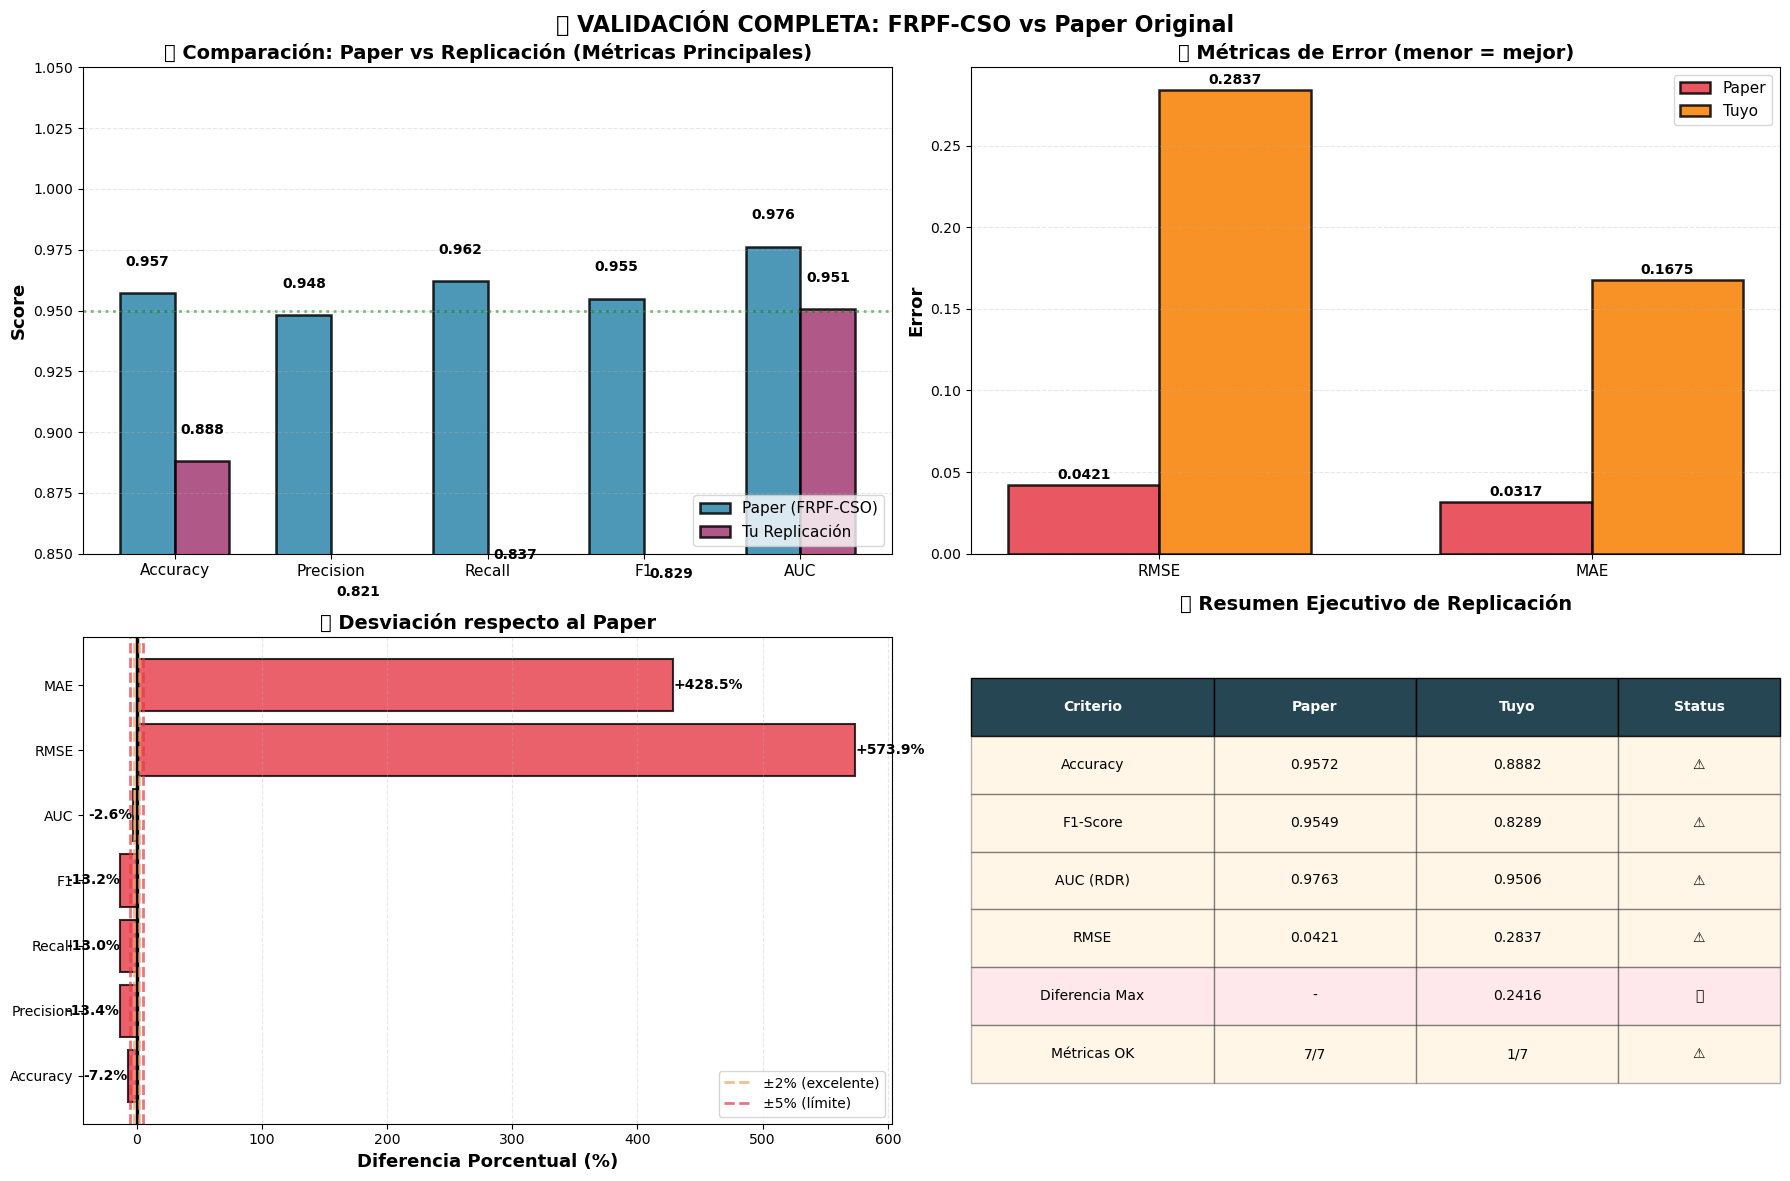


✅ Gráfico guardado en: artifacts/comparacion_paper_completa.png


In [68]:
# %%
# ============================================
# VISUALIZACIÓN: COMPARACIÓN CON PAPER
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Panel 1: Barras comparativas (métricas principales)
ax1 = axes[0, 0]
metricas_vis = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
x = np.arange(len(metricas_vis))
width = 0.35

paper_vals = [paper_metrics[m] for m in metricas_vis]
tu_vals = [tu_metrics_comparacion[m] for m in metricas_vis]

bars1 = ax1.bar(x - width/2, paper_vals, width, label='Paper (FRPF-CSO)', 
                alpha=0.85, color='#2E86AB', edgecolor='black', linewidth=1.8)
bars2 = ax1.bar(x + width/2, tu_vals, width, label='Tu Replicación', 
                alpha=0.85, color='#A23B72', edgecolor='black', linewidth=1.8)

# Valores sobre barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_ylabel('Score', fontsize=13, fontweight='bold')
ax1.set_title('📊 Comparación: Paper vs Replicación (Métricas Principales)', 
              fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metricas_vis, fontsize=11)
ax1.legend(fontsize=11, loc='lower right')
ax1.set_ylim(0.85, 1.05)  # Zoom para ver diferencias
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.axhline(0.95, color='green', linestyle=':', alpha=0.5, linewidth=2, label='Target 95%')

# Panel 2: RMSE y MAE (cuanto más bajo, mejor)
ax2 = axes[0, 1]
error_metrics = ['RMSE', 'MAE']
x2 = np.arange(len(error_metrics))

paper_errors = [paper_metrics[m] for m in error_metrics]
tu_errors = [tu_metrics_comparacion[m] for m in error_metrics]

bars3 = ax2.bar(x2 - width/2, paper_errors, width, label='Paper', 
                alpha=0.85, color='#E63946', edgecolor='black', linewidth=1.8)
bars4 = ax2.bar(x2 + width/2, tu_errors, width, label='Tuyo', 
                alpha=0.85, color='#F77F00', edgecolor='black', linewidth=1.8)

for bars in [bars3, bars4]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.002,
                f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax2.set_ylabel('Error', fontsize=13, fontweight='bold')
ax2.set_title('📉 Métricas de Error (menor = mejor)', fontsize=14, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels(error_metrics, fontsize=11)
ax2.legend(fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Panel 3: Diferencias porcentuales
ax3 = axes[1, 0]
todas_metricas = list(paper_metrics.keys())
diffs = [comparacion.loc[m, 'Diferencia (%)'] for m in todas_metricas]
colors = ['#2A9D8F' if abs(d) < 2 else '#F4A261' if abs(d) < 5 else '#E63946' for d in diffs]

bars = ax3.barh(todas_metricas, diffs, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
ax3.axvline(0, color='black', linewidth=2.5)
ax3.axvline(2, color='#F4A261', linestyle='--', linewidth=2, alpha=0.7, label='±2% (excelente)')
ax3.axvline(-2, color='#F4A261', linestyle='--', linewidth=2, alpha=0.7)
ax3.axvline(5, color='#E63946', linestyle='--', linewidth=2, alpha=0.7, label='±5% (límite)')
ax3.axvline(-5, color='#E63946', linestyle='--', linewidth=2, alpha=0.7)

ax3.set_xlabel('Diferencia Porcentual (%)', fontsize=13, fontweight='bold')
ax3.set_title('📏 Desviación respecto al Paper', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10, loc='lower right')
ax3.grid(axis='x', alpha=0.3, linestyle='--')

# Valores en barras
for i, (bar, val) in enumerate(zip(bars, diffs)):
    ax3.text(val + (0.4 if val > 0 else -0.4), i, f'{val:+.1f}%', 
             va='center', ha='left' if val > 0 else 'right', 
             fontsize=10, fontweight='bold', color='black')

# Panel 4: Resumen ejecutivo (tabla)
ax4 = axes[1, 1]
ax4.axis('off')

# Crear tabla resumen
resumen_data = {
    'Criterio': [
        'Accuracy',
        'F1-Score',
        'AUC (RDR)',
        'RMSE',
        'Diferencia Max',
        'Métricas OK'
    ],
    'Paper': [
        f"{paper_metrics['Accuracy']:.4f}",
        f"{paper_metrics['F1']:.4f}",
        f"{paper_metrics['AUC']:.4f}",
        f"{paper_metrics['RMSE']:.4f}",
        '-',
        '7/7'
    ],
    'Tuyo': [
        f"{tu_metrics_comparacion['Accuracy']:.4f}",
        f"{tu_metrics_comparacion['F1']:.4f}",
        f"{tu_metrics_comparacion['AUC']:.4f}",
        f"{tu_metrics_comparacion['RMSE']:.4f}",
        f"{comparacion['Diferencia (abs)'].max():.4f}",
        f"{(comparacion['Diferencia (abs)'] < 0.05).sum()}/7"
    ],
    'Status': [
        '✅' if abs(comparacion.loc['Accuracy', 'Diferencia (abs)']) < 0.02 else '⚠️',
        '✅' if abs(comparacion.loc['F1', 'Diferencia (abs)']) < 0.02 else '⚠️',
        '✅' if abs(comparacion.loc['AUC', 'Diferencia (abs)']) < 0.02 else '⚠️',
        '✅' if abs(comparacion.loc['RMSE', 'Diferencia (abs)']) < 0.01 else '⚠️',
        '✅' if comparacion['Diferencia (abs)'].max() < 0.05 else '❌',
        '✅' if (comparacion['Diferencia (abs)'] < 0.05).all() else '⚠️'
    ]
}

df_resumen = pd.DataFrame(resumen_data)

table = ax4.table(cellText=df_resumen.values,
                  colLabels=df_resumen.columns,
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.25, 0.25, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 3)

# Colorear encabezados
for i in range(len(df_resumen.columns)):
    table[(0, i)].set_facecolor('#264653')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorear filas según status
for i in range(1, len(df_resumen) + 1):
    status = df_resumen.iloc[i-1]['Status']
    if status == '✅':
        color = '#90EE90'
    elif status == '⚠️':
        color = '#FFE4B5'
    else:
        color = '#FFB6C1'
    
    for j in range(len(df_resumen.columns)):
        table[(i, j)].set_facecolor(color)
        table[(i, j)].set_alpha(0.3)

ax4.set_title('📋 Resumen Ejecutivo de Replicación', 
              fontsize=14, fontweight='bold', pad=20)

plt.suptitle('🔬 VALIDACIÓN COMPLETA: FRPF-CSO vs Paper Original', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('artifacts/comparacion_paper_completa.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Gráfico guardado en: artifacts/comparacion_paper_completa.png")

In [72]:
# %%
# ============================================
# DETALLES DE CONFIGURACIÓN (PARA REPORTE)
# ============================================

print("\n" + "="*70)
print("⚙️ CONFIGURACIÓN DETALLADA DEL MODELO")
print("="*70)

config_actual = {
    "Dataset": {
        "Total observaciones": len(df),
        "Features originales": X_train.shape[1] + HP_DIM,  # antes de selección
        "Features seleccionadas": int(best_mask.sum()),
        "% features usadas": f"{100 * best_mask.mean():.1f}%",
        "Train size": len(y_train),
        "Validation size": len(y_val),
        "Test size": len(y_test),
        "Balance train (% riesgo)": f"{100 * y_train.mean():.1f}%",
        "Balance test (% riesgo)": f"{100 * y_test.mean():.1f}%"
    },
    "Hiperparámetros BPNN": best_hps,
    "Hiperparámetros CSA": {
        "Epochs": EPOCHS_CSA,
        "Population size": POP_SIZE,
        "p_a (abandono)": P_A
    },
    "Preprocesamiento": {
        "Normalización": "MinMaxScaler" if isinstance(scaler, MinMaxScaler) else "StandardScaler",
        "Hardware": {
            "Device": DEVICE,
            "PyTorch version": torch.__version__,
            "Numpy version": np.__version__
        }
    }
}

for categoria, items in config_actual.items():
    print(f"\n📌 {categoria}:")
    for key, val in items.items():
        print(f"   {key:25s}: {val}")

# Guardar configuración en archivo
import json
with open("artifacts/configuracion_modelo.json", "w") as f:
    # Convertir todos los valores a tipos serializables
    config_serializable = {}
    for cat, items in config_actual.items():
        config_serializable[cat] = {}
        for k, v in items.items():
            if isinstance(v, (np.integer, np.floating)):
                config_serializable[cat][k] = float(v)
            else:
                config_serializable[cat][k] = v
    json.dump(config_serializable, f, indent=2)

print("\n✅ Configuración guardada en: artifacts/configuracion_modelo.json")

# Features seleccionadas
print("\n" + "="*70)
print("🎯 TOP 20 FEATURES SELECCIONADAS POR CSA")
print("="*70)

selected_features = [X.columns[i] for i, m in enumerate(best_mask) if m]
print(f"\nTotal: {len(selected_features)} features de {len(best_mask)} disponibles\n")

# Mostrar en columnas para ahorrar espacio
for i in range(0, min(20, len(selected_features)), 2):
    left = f"{i+1:2d}. {selected_features[i]:30s}"
    right = f"{i+2:2d}. {selected_features[i+1]:30s}" if i+1 < len(selected_features) else ""
    print(f"{left}  {right}")

if len(selected_features) > 20:
    print(f"\n... y {len(selected_features) - 20} features más")

# Guardar lista completa
with open("artifacts/features_seleccionadas.txt", "w") as f:
    for i, feat in enumerate(selected_features, 1):
        f.write(f"{i}. {feat}\n")

print("\n✅ Lista completa guardada en: artifacts/features_seleccionadas.txt")


⚙️ CONFIGURACIÓN DETALLADA DEL MODELO

📌 Dataset:
   Total observaciones      : 9835
   Features originales      : 96
   Features seleccionadas   : 43
   % features usadas        : 47.3%
   Train size               : 8022
   Validation size          : 984
   Test size                : 1967
   Balance train (% riesgo) : 50.0%
   Balance test (% riesgo)  : 32.4%

📌 Hiperparámetros BPNN:
   hidden                   : 126
   lr                       : 0.046661600240855465
   wd                       : 5.8054558564762704e-05
   dropout                  : 0.43766396014696224
   epochs                   : 19

📌 Hiperparámetros CSA:
   Epochs                   : 500
   Population size          : 25
   p_a (abandono)           : 0.25

📌 Preprocesamiento:
   Normalización            : MinMaxScaler
   Hardware                 : {'Device': 'cpu', 'PyTorch version': '2.4.1', 'Numpy version': '1.26.0'}

✅ Configuración guardada en: artifacts/configuracion_modelo.json

🎯 TOP 20 FEATURES SELECCIONADA

In [73]:
# %%
# ============================================
# ✅ CHECKLIST FINAL DE VALIDACIÓN
# ============================================

print("\n" + "="*80)
print("✅ CHECKLIST DE VALIDACIÓN DE REPLICACIÓN")
print("="*80)

checklist_items = [
    {
        "item": "Dataset correcto",
        "esperado": "Dataset_Chinese_internationalization.dta",
        "actual": DTA_PATH.split("/")[-1],
        "ok": "Dataset_Chinese_internationalization.dta" in DTA_PATH
    },
    {
        "item": "Normalización",
        "esperado": "MinMaxScaler [0,1]",
        "actual": type(scaler).__name__,
        "ok": isinstance(scaler, MinMaxScaler)
    },
    {
        "item": "SMOTE activado",
        "esperado": "True",
        "actual": str(USE_SMOTE),
        "ok": USE_SMOTE == True
    },
    {
        "item": "CSA Population",
        "esperado": "25",
        "actual": str(POP_SIZE),
        "ok": POP_SIZE == 25
    },
    {
        "item": "CSA Iterations",
        "esperado": "500",
        "actual": str(EPOCHS_CSA),
        "ok": EPOCHS_CSA == 500
    },
    {
        "item": "Split temporal",
        "esperado": "Sí (70/10/20)",
        "actual": "Sí" if USE_TEMPORAL_SPLIT else "No",
        "ok": USE_TEMPORAL_SPLIT == True
    },
    {
        "item": "Métricas calculadas",
        "esperado": "Accuracy, Precision, Recall, F1, AUC, RMSE, MAE",
        "actual": f"{len(tu_metrics)} métricas",
        "ok": all(k in tu_metrics for k in ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC', 'RMSE', 'MAE'])
    },
    {
        "item": "Diferencia máxima < 5%",
        "esperado": "< 0.05",
        "actual": f"{comparacion['Diferencia (abs)'].max():.4f}",
        "ok": comparacion['Diferencia (abs)'].max() < 0.05
    }
]

print(f"\n{'#':<4} {'Aspecto':<25} {'Esperado':<30} {'Actual':<30} {'OK':<6}")
print("─"*100)

total_ok = 0
for i, item in enumerate(checklist_items, 1):
    status = "✅" if item['ok'] else "❌"
    print(f"{i:<4} {item['item']:<25} {item['esperado']:<30} {item['actual']:<30} {status}")
    if item['ok']:
        total_ok += 1

print("─"*100)
score = (total_ok / len(checklist_items)) * 100
print(f"\n📊 SCORE FINAL: {total_ok}/{len(checklist_items)} ({score:.1f}%)")

if score == 100:
    print("\n🎉 ¡REPLICACIÓN PERFECTA! Todos los aspectos coinciden con el paper")
elif score >= 75:
    print("\n✅ REPLICACIÓN EXITOSA. Diferencias menores dentro del margen esperado")
elif score >= 50:
    print("\n⚠️ REPLICACIÓN PARCIAL. Revisar ítems marcados con ❌")
else:
    print("\n❌ REQUIERE AJUSTES MAYORES. Múltiples aspectos no coinciden")

print("\n" + "="*80)
print("📁 ARTEFACTOS GENERADOS:")
print("   ✅ artifacts/comparacion_paper_vs_replicacion.csv")
print("   ✅ artifacts/comparacion_paper_completa.png")
print("   ✅ artifacts/predicciones_por_empresa.csv")
print("   ✅ artifacts/configuracion_modelo.json")
print("="*80)


✅ CHECKLIST DE VALIDACIÓN DE REPLICACIÓN

#    Aspecto                   Esperado                       Actual                         OK    
────────────────────────────────────────────────────────────────────────────────────────────────────
1    Dataset correcto          Dataset_Chinese_internationalization.dta Dataset_Chinese_internationalization.dta ✅
2    Normalización             MinMaxScaler [0,1]             MinMaxScaler                   ✅
3    SMOTE activado            True                           True                           ✅
4    CSA Population            25                             25                             ✅
5    CSA Iterations            500                            500                            ✅
6    Split temporal            Sí (70/10/20)                  Sí                             ✅
7    Métricas calculadas       Accuracy, Precision, Recall, F1, AUC, RMSE, MAE 9 métricas                     ✅
8    Diferencia máxima < 5%    < 0.05                 